### Importing key libraries

In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Visualize training data

Processing image: 922.png


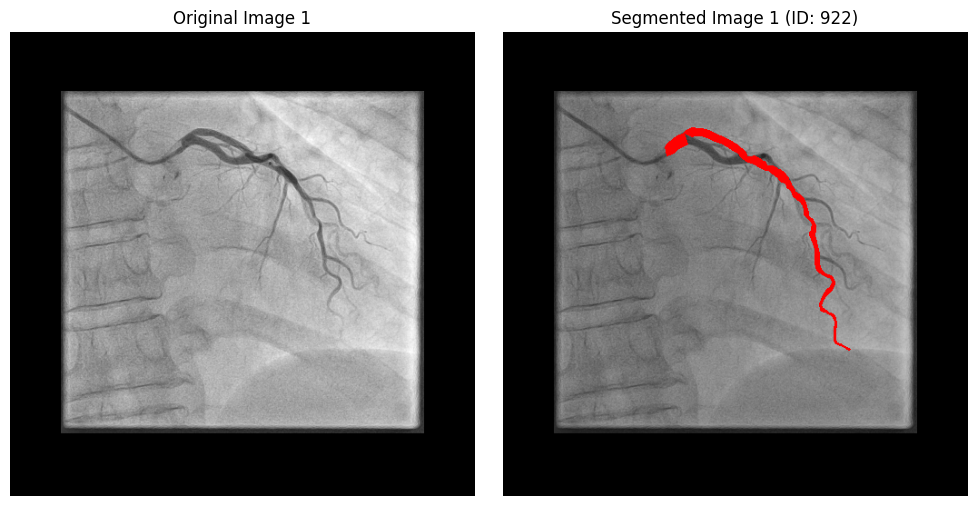

Processing image: 793.png


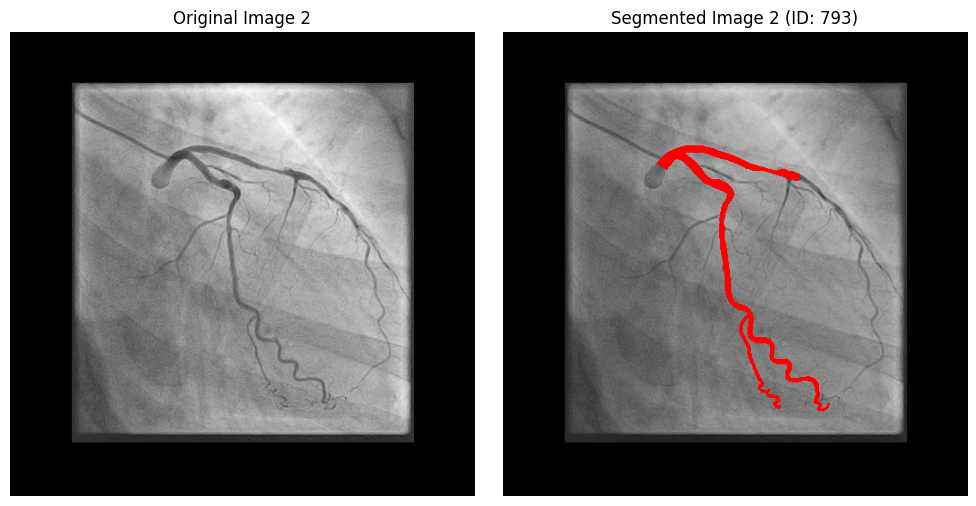

Processing image: 782.png


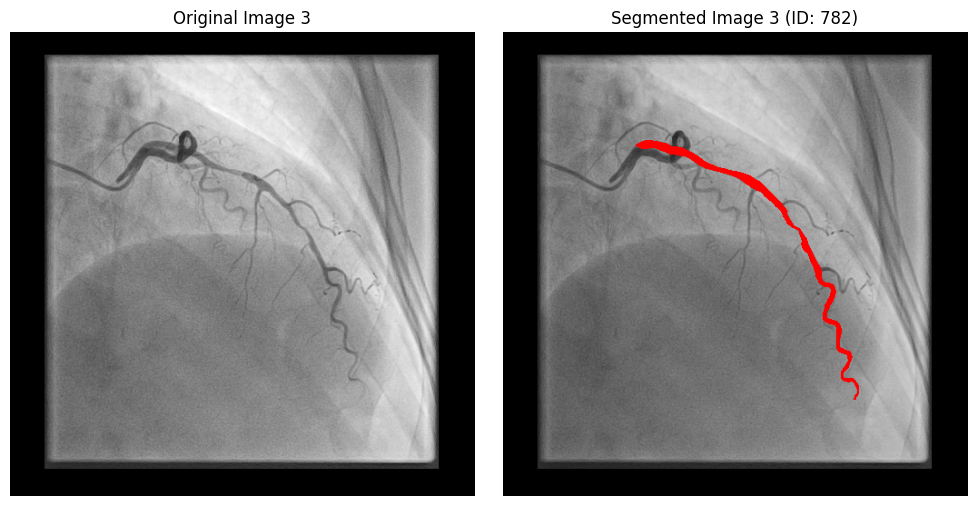

Processing image: 660.png


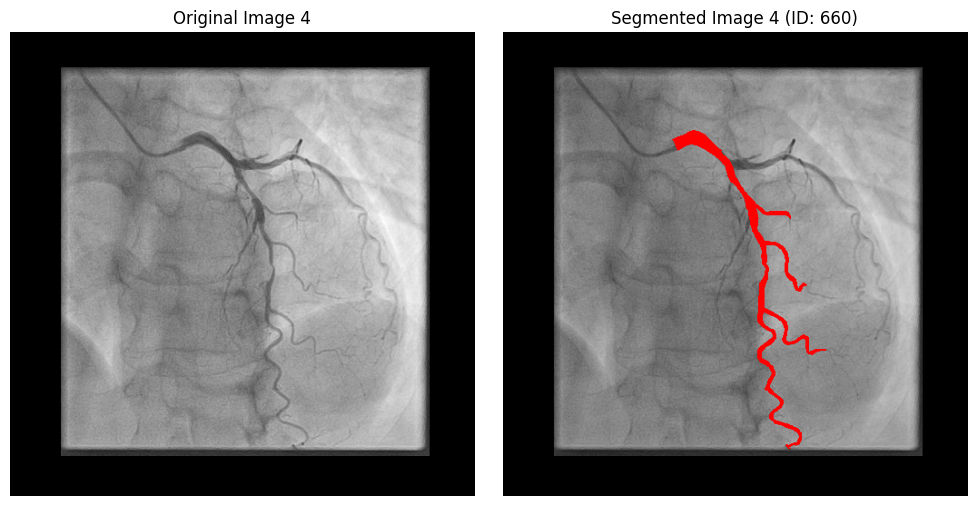

Processing image: 708.png


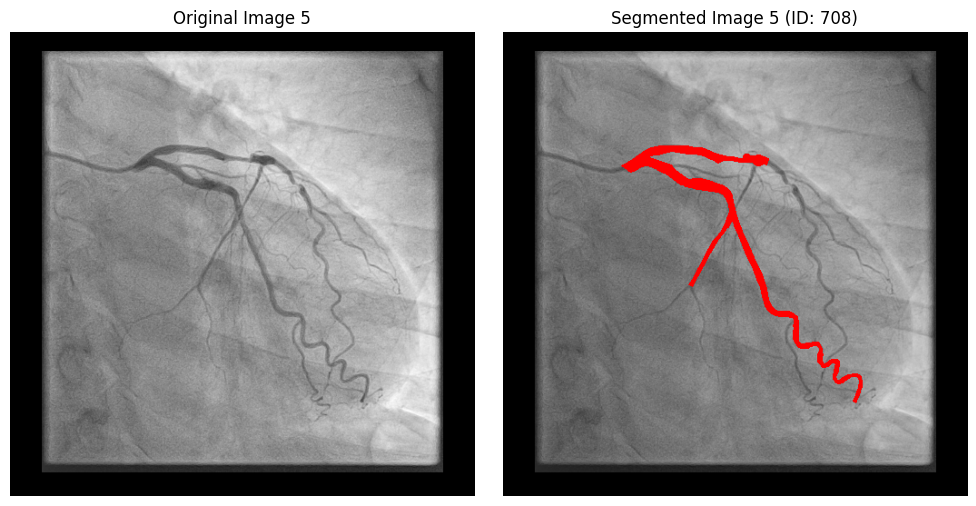

In [2]:
def load_json_annotations(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

def create_mask(image_shape, segmentation):
    mask = np.zeros(image_shape, dtype=np.uint8)
    # Convert XYXY segmentation points to a list of points for OpenCV
    points = np.array(segmentation, dtype=np.int32).reshape(-1, 2)
    # Fill the polygon defined by segmentation points
    cv2.fillPoly(mask, [points], color=255)
    return mask

def visualize_segmentation(image_path, annotations, categories, image_id, image_index):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")

    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Find annotations for the given image_id
    img_annotations = [ann for ann in annotations if ann['image_id'] == image_id]
    # Create a mask for visualization
    mask = np.zeros_like(img, dtype=np.uint8)
    
    for ann in img_annotations:
        category_id = ann['category_id']
        category_name = next(cat['name'] for cat in categories if cat['id'] == category_id)
        segmentation = ann['segmentation']
        
        # Create individual mask for this annotation
        ann_mask = create_mask(img.shape, segmentation)
        mask = np.maximum(mask, ann_mask)  # Combine masks
        
        # Add mask to image (highlight in red for visibility)
        img_color[ann_mask == 255] = [255, 0, 0]  # Red for segmentation
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image {image_index + 1}")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title(f"Segmented Image {image_index + 1} (ID: {image_id})")
    plt.imshow(img_color)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return mask


base_path = "datasets/arcade/syntax"
train_images_path = os.path.join(base_path, "train", "images")
train_json_path = os.path.join(base_path, "train", "annotations", "train.json")

# Load JSON annotations
data = load_json_annotations(train_json_path)
images = data['images']
annotations = data['annotations']
categories = data['categories']

# Process the first 5 images
for idx, sample_image in enumerate(images[:5]):
    image_id = sample_image['id']
    image_file = sample_image['file_name']
    image_path = os.path.join(train_images_path, image_file)
    
    print(f"Processing image: {image_file}")
    visualize_segmentation(image_path, annotations, categories, image_id, idx)

### Loss and metrics

In [3]:
# Dice Loss for handling class imbalance
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        # Apply sigmoid here, or ensure model's final layer doesn't apply it if using BCEWithLogitsLoss
        # For DiceLoss, it's common to apply sigmoid to predictions.
        pred = torch.sigmoid(pred) 
        # Flatten tensors for calculation to handle batch dimension implicitly
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        # Add epsilon for numerical stability
        dice = (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)
        return 1 - dice
    
    
# Evaluation Metrics
def calculate_iou(pred, target, threshold=0.5):
    # Ensure pred is passed through sigmoid if it's raw logits from model
    pred = (torch.sigmoid(pred) > threshold).float()
    # Flatten for easier calculation across batch and spatial dimensions
    pred_flat = pred.view(pred.shape[0], -1)
    target_flat = target.view(target.shape[0], -1)
    intersection = (pred_flat * target_flat).sum(dim=1)
    union = (pred_flat + target_flat).sum(dim=1) - intersection
    # Handle cases where union might be zero (e.g., both pred and target are empty)
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def calculate_dice(pred, target, threshold=0.5):
    # Ensure pred is passed through sigmoid if it's raw logits from model
    pred = (torch.sigmoid(pred) > threshold).float()
    # Flatten for easier calculation across batch and spatial dimensions
    pred_flat = pred.view(pred.shape[0], -1)
    target_flat = target.view(target.shape[0], -1)
    intersection = (pred_flat * target_flat).sum(dim=1)
    dice = (2 * intersection + 1e-6) / (pred_flat.sum(dim=1) + target_flat.sum(dim=1) + 1e-6)
    return dice.mean().item()

### Dataset class

In [4]:
class ARCADE_Dataset(Dataset):
    def __init__(self, images_dir, json_path, img_size=(512, 512), transform=None):
        self.images_dir = Path(images_dir) # Use Pathlib for better path manipulation
        self.img_size = img_size
        self.transform = transform
        
        if not self.images_dir.exists():
            raise FileNotFoundError(f"Images directory not found: {images_dir}")
        if not Path(json_path).exists():
            raise FileNotFoundError(f"JSON annotation file not found: {json_path}")

        with open(json_path, 'r') as f:
            self.data = json.load(f)
        
        self.images = self.data['images']
        self.annotations = self.data['annotations']
        self.categories = self.data['categories']

        # Create a mapping from image_id to its annotations for faster lookup
        self.image_annotations_map = {}
        for ann in self.annotations:
            image_id = ann['image_id']
            if image_id not in self.image_annotations_map:
                self.image_annotations_map[image_id] = []
            self.image_annotations_map[image_id].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        image_id = img_info['id']
        image_path = self.images_dir / img_info['file_name'] # Use Pathlib for joining paths
        
        # Load and preprocess image
        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE) # cv2.imread takes string
        if img is None:
            # Instead of raising ValueError, which might stop training,
            # consider returning None and filtering in DataLoader, or a dummy image/mask
            # For simplicity in this example, we'll raise for clarity.
            raise ValueError(f"Could not load image at {image_path}. Check file integrity.")
        
        original_height, original_width = img.shape[:2] # Get original dimensions
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)
        img = img / 255.0
        
        # Create binary mask
        mask = np.zeros(self.img_size, dtype=np.uint8)
        
        # Use the pre-built map for faster annotation retrieval
        img_annotations = self.image_annotations_map.get(image_id, []) 
        
        if not img_annotations:
            # print(f"Warning: No annotations found for image {img_info['file_name']}")
            pass # It's valid to have images with no annotations (background)

        for ann in img_annotations:
            # Ensure 'segmentation' is a list of polygons, even if it's just one
            segmentations = ann['segmentation']
            if not isinstance(segmentations, list) or not all(isinstance(s, list) for s in segmentations):
                # Handle cases where segmentation might be a single flat list of points
                # instead of a list of lists (for multiple polygons).
                segmentations = [segmentations] 

            for segmentation_points in segmentations:
                if not segmentation_points: # Skip empty segmentations
                    continue
                points = np.array(segmentation_points, dtype=np.float32).reshape(-1, 2)
                
                # Scale points to match resized image
                # Ensure correct scaling factors (width vs height)
                scale_x = self.img_size[0] / original_width
                scale_y = self.img_size[1] / original_height
                points[:, 0] = points[:, 0] * scale_x
                points[:, 1] = points[:, 1] * scale_y
                
                points = points.astype(np.int32)
                
                # Ensure points are within bounds before filling polygon
                # This clipping might distort shapes at the edges, but prevents errors.
                points[:, 0] = np.clip(points[:, 0], 0, self.img_size[0] - 1)
                points[:, 1] = np.clip(points[:, 1], 0, self.img_size[1] - 1)

                if points.size > 0: # Ensure there are points to draw
                    cv2.fillPoly(mask, [points], color=1)  # Binary mask: 1 for segmented region
        
        # Convert to tensors
        # Add channel dimension before applying transforms if transform expects it.
        # Otherwise, transforms will operate on 2D arrays, which might not be intended.
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # [1, H, W]
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # [1, H, W]
        
        if self.transform:
            # Apply transform to both image and mask if they are spatial transforms
            # For transforms that change pixel values (e.g., color jitter), apply only to image.
            # For this U-Net setup, assuming spatial transforms are applied consistently.
            # A more robust solution would involve torchvision.transforms.functional for masks.
            seed = torch.seed() # Preserve randomness across image and mask transforms
            torch.manual_seed(seed)
            img_tensor = self.transform(img_tensor)
            torch.manual_seed(seed) # Apply same random transformation
            mask_tensor = self.transform(mask_tensor)

        return img_tensor, mask_tensor

### Training loop & pred. viz

In [5]:
def train_model(model, train_loader, val_loader, num_epochs=60, device='cuda', deep_supervision=False):
    model = model.to(device)
    criterion_bce = nn.BCEWithLogitsLoss() 
    criterion_dice = DiceLoss() 
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    train_losses, val_losses, val_ious, val_dices = [], [], [], []
    
    best_val_loss = float('inf')
    best_epoch = -1

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)

            if deep_supervision:
                loss = 0
                for output in outputs:
                    loss_bce = criterion_bce(output, masks)
                    loss_dice = criterion_dice(output, masks)
                    loss += (0.5 * loss_bce + 0.5 * loss_dice)
                loss /= len(outputs) 
            else:
                loss_bce = criterion_bce(outputs, masks)
                loss_dice = criterion_dice(outputs, masks)
                loss = 0.5 * loss_bce + 0.5 * loss_dice 
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            if batch_idx % 50 == 0: 
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Train Loss: {loss.item():.4f}")
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss, val_iou, val_dice = 0, 0, 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)

                if deep_supervision:
                    batch_val_loss = 0
                    batch_val_iou = 0
                    batch_val_dice = 0
                    final_output = outputs[-1] 
                    loss_bce = criterion_bce(final_output, masks)
                    loss_dice = criterion_dice(final_output, masks)
                    batch_val_loss = (0.5 * loss_bce + 0.5 * loss_dice).item()
                    batch_val_iou = calculate_iou(final_output, masks)
                    batch_val_dice = calculate_dice(final_output, masks)
                    val_loss += batch_val_loss
                    val_iou += batch_val_iou
                    val_dice += batch_val_dice
                else:
                    loss_bce = criterion_bce(outputs, masks)
                    loss_dice = criterion_dice(outputs, masks)
                    val_loss += (0.5 * loss_bce + 0.5 * loss_dice).item()
                    val_iou += calculate_iou(outputs, masks)
                    val_dice += calculate_dice(outputs, masks)
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        val_losses.append(avg_val_loss)
        val_ious.append(avg_val_iou)
        val_dices.append(avg_val_dice)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}, Val Dice: {avg_val_dice:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), "best_unetpp_model.pth") 
            print(f"Saved best model at Epoch {epoch+1} with Val Loss: {best_val_loss:.4f}")

        scheduler.step(avg_val_loss)
            
    print(f"Training finished. Best model saved from Epoch {best_epoch+1} with Val Loss: {best_val_loss:.4f}")
    return model, train_losses, val_losses, val_ious, val_dices


def visualize_predictions(model, data_loader, device, num_images=5, deep_supervision=False):
    model.eval()
    with torch.no_grad():
        for idx, (images, masks) in enumerate(data_loader):
            if idx >= num_images:
                break
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            if deep_supervision:
                outputs = outputs[-1]
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5  # Threshold at 0.5
            
            img = images[0].cpu().numpy().squeeze()
            true_mask = masks[0].cpu().numpy().squeeze()
            pred_mask = preds[0].squeeze()
            
            print(f"Image {idx+1}: True mask sum: {true_mask.sum()}, Predicted mask sum: {pred_mask.sum()}")
            
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.title("Ground Truth Mask")
            plt.imshow(true_mask, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(pred_mask, cmap='gray')
            plt.axis('off')
            
            plt.show()

### Preparing data and loaders

In [6]:
base_path = "datasets/arcade/syntax"
train_images_path = os.path.join(base_path, "train", "images")
train_json_path = os.path.join(base_path, "train", "annotations", "train.json")
val_images_path = os.path.join(base_path, "val", "images")
val_json_path = os.path.join(base_path, "val", "annotations", "val.json")

# Data augmentation (important: apply to both image and mask consistently)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
])

try:
    train_dataset = ARCADE_Dataset(train_images_path, train_json_path, transform=transform)
    val_dataset = ARCADE_Dataset(val_images_path, val_json_path)
except FileNotFoundError as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the dataset paths are correct and the files exist.")
except Exception as e:
    print(f"An unexpected error occurred during dataset loading: {e}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=os.cpu_count() // 2 or 1) # Use more workers
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=os.cpu_count() // 2 or 1)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Train dataset size: 1000
Validation dataset size: 200
Using device: cuda


### U-Net architecture

In [7]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, 1, 1)  # Output: 1 channel (binary mask)
        
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder
        d4 = self.upconv4(b)
        # Ensure correct spatial dimensions for concatenation in case of odd sizes
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        out = self.final_conv(d1)
        return out

Training U-Net...
Epoch 1/60, Batch 0/250, Train Loss: 0.8043
Epoch 1/60, Batch 50/250, Train Loss: 0.5394
Epoch 1/60, Batch 100/250, Train Loss: 0.5216
Epoch 1/60, Batch 150/250, Train Loss: 0.5258
Epoch 1/60, Batch 200/250, Train Loss: 0.4570
Epoch 1/60, Train Loss: 0.5354, Val Loss: 0.5168, Val IoU: 0.0862, Val Dice: 0.1437
Saved best model at Epoch 1 with Val Loss: 0.5168
Epoch 2/60, Batch 0/250, Train Loss: 0.4768
Epoch 2/60, Batch 50/250, Train Loss: 0.3595
Epoch 2/60, Batch 100/250, Train Loss: 0.4132
Epoch 2/60, Batch 150/250, Train Loss: 0.2978
Epoch 2/60, Batch 200/250, Train Loss: 0.3878
Epoch 2/60, Train Loss: 0.3875, Val Loss: 0.3204, Val IoU: 0.3358, Val Dice: 0.4848
Saved best model at Epoch 2 with Val Loss: 0.3204
Epoch 3/60, Batch 0/250, Train Loss: 0.2376
Epoch 3/60, Batch 50/250, Train Loss: 0.3010
Epoch 3/60, Batch 100/250, Train Loss: 0.2363
Epoch 3/60, Batch 150/250, Train Loss: 0.2091
Epoch 3/60, Batch 200/250, Train Loss: 0.2125
Epoch 3/60, Train Loss: 0.2631, V

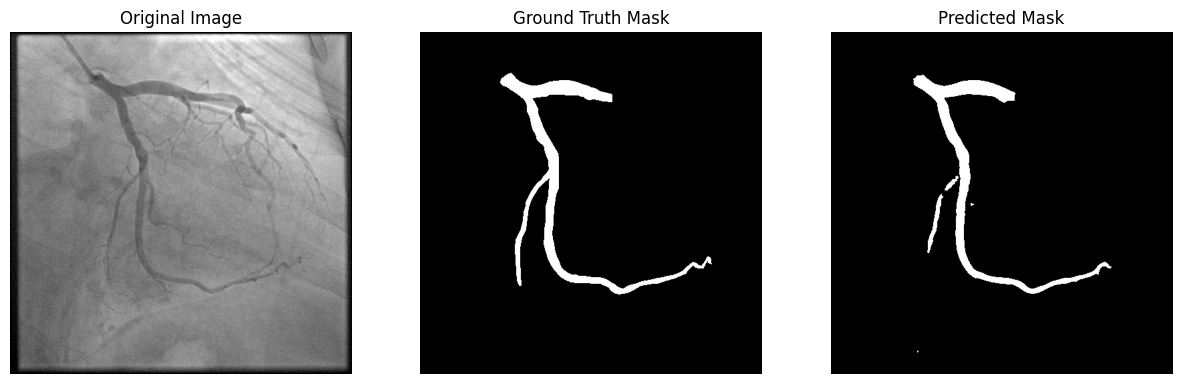

Image 2: True mask sum: 7860.0, Predicted mask sum: 5393


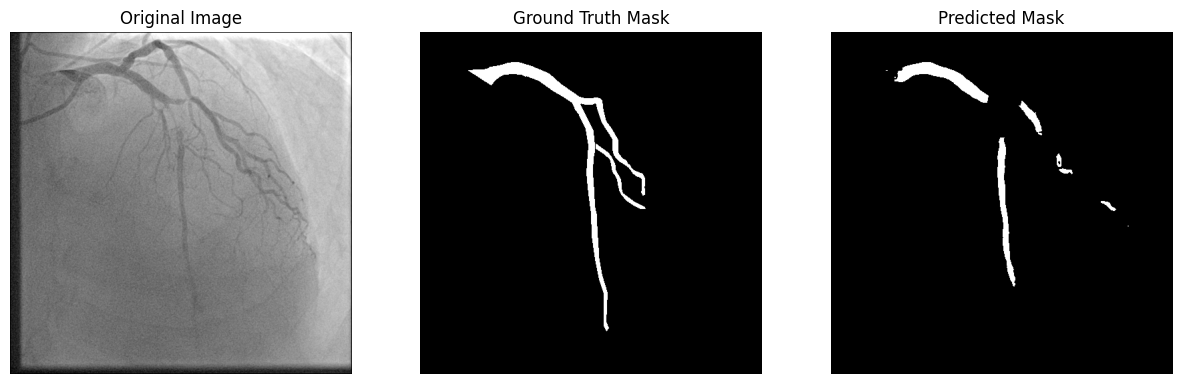

Image 3: True mask sum: 6711.0, Predicted mask sum: 3575


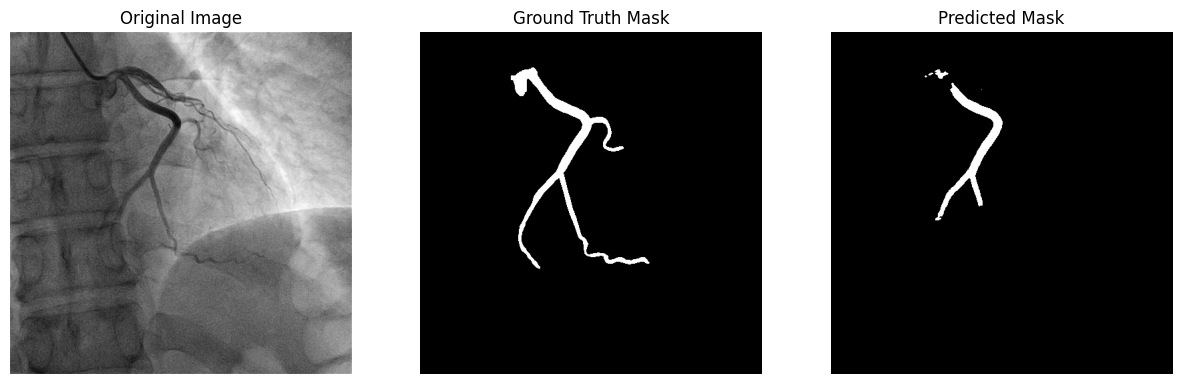

Image 4: True mask sum: 5394.0, Predicted mask sum: 7382


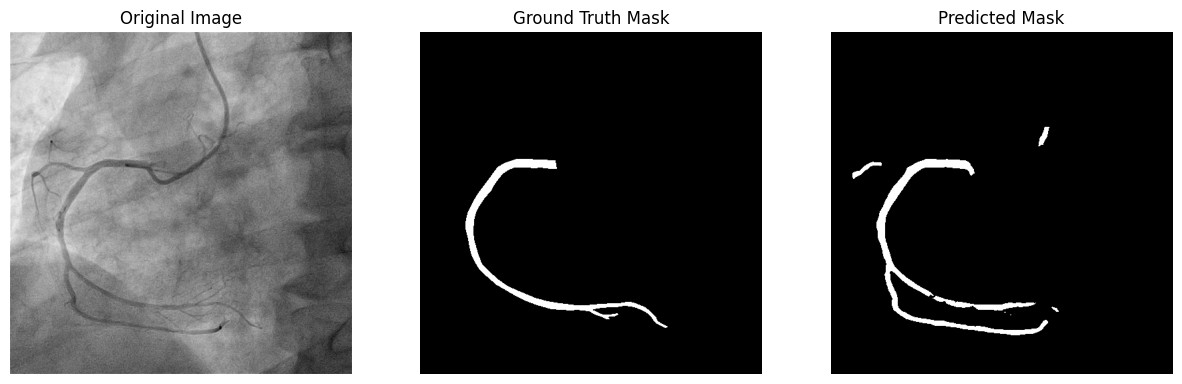

Image 5: True mask sum: 9790.0, Predicted mask sum: 11245


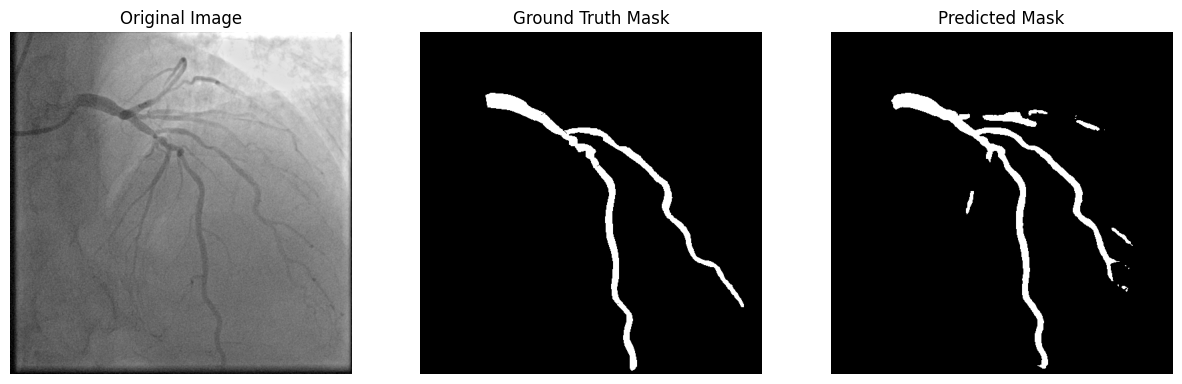

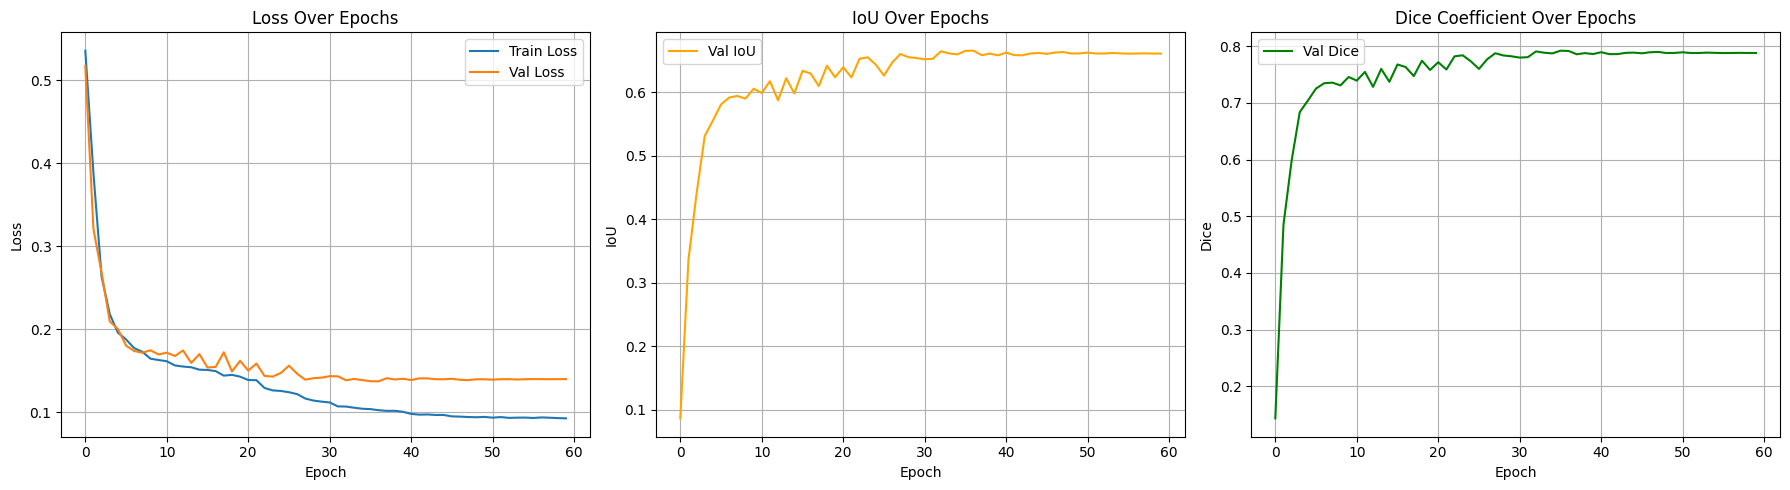

In [8]:
print("Training U-Net...")
unet_model = UNet()
trained_unet, train_losses, val_losses, val_ious, val_dices = train_model(
    unet_model, train_loader, val_loader, num_epochs=60, device=device)

# Load the best model's state dict for final visualization and evaluation
if Path("best_unet_model.pth").exists():
    trained_unet.load_state_dict(torch.load("best_unet_model.pth"))
    print("Loaded best model for visualization.")
else:
    print("No best model saved. Using the last trained model.")

# Visualize U-Net predictions
print("Visualizing U-Net predictions...")
visualize_predictions(trained_unet, val_loader, device, num_images=5)

# Plot training metrics
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_ious, label='Val IoU', color='orange')
plt.title('IoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(val_dices, label='Val Dice', color='green')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### U-Net++ architecture

In [9]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class NestedUNet(nn.Module):
    def __init__(self, num_classes=1, input_channels=1, deep_supervision=False):
        super().__init__()

        self.num_classes = num_classes
        self.deep_supervision = deep_supervision
        self.feature_scale = 2 # Scaling factor for initial feature maps (not directly used here but common in some U-Net++ variants)

        filters = [32, 64, 128, 256, 512] # Base filter sizes

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # X_0,0
        self.conv0_0 = VGGBlock(input_channels, filters[0], filters[0])
        
        # X_1,0, X_0,1
        self.conv1_0 = VGGBlock(filters[0], filters[1], filters[1])
        # Input to conv0_1: x0_0 (filters[0]) + up(x1_0) (filters[1]) = filters[0] + filters[1]
        self.conv0_1 = VGGBlock(filters[0] + filters[1], filters[0], filters[0])

        # X_2,0, X_1,1, X_0,2
        self.conv2_0 = VGGBlock(filters[1], filters[2], filters[2])
        # Input to conv1_1: x1_0 (filters[1]) + up(x2_0) (filters[2]) = filters[1] + filters[2]
        self.conv1_1 = VGGBlock(filters[1] + filters[2], filters[1], filters[1])
        # Input to conv0_2: x0_0 (filters[0]) + x0_1 (filters[0]) + up(x1_1) (filters[1]) = 2*filters[0] + filters[1]
        self.conv0_2 = VGGBlock(filters[0]*2 + filters[1], filters[0], filters[0]) 

        # X_3,0, X_2,1, X_1,2, X_0,3
        self.conv3_0 = VGGBlock(filters[2], filters[3], filters[3])
        # Input to conv2_1: x2_0 (filters[2]) + up(x3_0) (filters[3]) = filters[2] + filters[3]
        self.conv2_1 = VGGBlock(filters[2] + filters[3], filters[2], filters[2])
        # Input to conv1_2: x1_0 (filters[1]) + x1_1 (filters[1]) + up(x2_1) (filters[2]) = 2*filters[1] + filters[2]
        self.conv1_2 = VGGBlock(filters[1]*2 + filters[2], filters[1], filters[1])
        # Input to conv0_3: x0_0 (filters[0]) + x0_1 (filters[0]) + x0_2 (filters[0]) + up(x1_2) (filters[1]) = 3*filters[0] + filters[1]
        self.conv0_3 = VGGBlock(filters[0]*3 + filters[1], filters[0], filters[0])

        # X_4,0, X_3,1, X_2,2, X_1,3, X_0,4
        self.conv4_0 = VGGBlock(filters[3], filters[4], filters[4])
        # Input to conv3_1: x3_0 (filters[3]) + up(x4_0) (filters[4]) = filters[3] + filters[4]
        self.conv3_1 = VGGBlock(filters[3] + filters[4], filters[3], filters[3])
        # Input to conv2_2: x2_0 (filters[2]) + x2_1 (filters[2]) + up(x3_1) (filters[3]) = 2*filters[2] + filters[3]
        self.conv2_2 = VGGBlock(filters[2]*2 + filters[3], filters[2], filters[2])
        # Input to conv1_3: x1_0 (filters[1]) + x1_1 (filters[1]) + x1_2 (filters[1]) + up(x2_2) (filters[2]) = 3*filters[1] + filters[2]
        self.conv1_3 = VGGBlock(filters[1]*3 + filters[2], filters[1], filters[1])
        # Input to conv0_4: x0_0 (filters[0]) + x0_1 (filters[0]) + x0_2 (filters[0]) + x0_3 (filters[0]) + up(x1_3) (filters[1]) = 4*filters[0] + filters[1]
        self.conv0_4 = VGGBlock(filters[0]*4 + filters[1], filters[0], filters[0])

        # Output classifiers for deep supervision
        if self.deep_supervision:
            self.output1 = nn.Conv2d(filters[0], num_classes, 1)
            self.output2 = nn.Conv2d(filters[0], num_classes, 1)
            self.output3 = nn.Conv2d(filters[0], num_classes, 1)
            self.output4 = nn.Conv2d(filters[0], num_classes, 1)
        else:
            self.output = nn.Conv2d(filters[0], num_classes, 1)

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        # Note: x0_0, x0_1 are from previous levels at the same resolution
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        # Note: x1_0, x1_1 are from previous levels at the same resolution
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        # Note: x0_0, x0_1, x0_2 are from previous levels at the same resolution
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        # Note: x2_0, x2_1 are from previous levels at the same resolution
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        # Note: x1_0, x1_1, x1_2 are from previous levels at the same resolution
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        # Note: x0_0, x0_1, x0_2, x0_3 are from previous levels at the same resolution
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.output1(x0_1)
            output2 = self.output2(x0_2)
            output3 = self.output3(x0_3)
            output4 = self.output4(x0_4)
            return [output1, output2, output3, output4]
        else:
            return self.output(x0_4)

Training U-Net++...
Epoch 1/60, Batch 0/250, Train Loss: 0.7698
Epoch 1/60, Batch 50/250, Train Loss: 0.5749
Epoch 1/60, Batch 100/250, Train Loss: 0.5046
Epoch 1/60, Batch 150/250, Train Loss: 0.4679
Epoch 1/60, Batch 200/250, Train Loss: 0.4095
Epoch 1/60, Train Loss: 0.4781, Val Loss: 0.3398, Val IoU: 0.5215, Val Dice: 0.6769
Saved best model at Epoch 1 with Val Loss: 0.3398
Epoch 2/60, Batch 0/250, Train Loss: 0.3375
Epoch 2/60, Batch 50/250, Train Loss: 0.2614
Epoch 2/60, Batch 100/250, Train Loss: 0.2686
Epoch 2/60, Batch 150/250, Train Loss: 0.2666
Epoch 2/60, Batch 200/250, Train Loss: 0.1937
Epoch 2/60, Train Loss: 0.2617, Val Loss: 0.2228, Val IoU: 0.5469, Val Dice: 0.6957
Saved best model at Epoch 2 with Val Loss: 0.2228
Epoch 3/60, Batch 0/250, Train Loss: 0.1831
Epoch 3/60, Batch 50/250, Train Loss: 0.2658
Epoch 3/60, Batch 100/250, Train Loss: 0.2155
Epoch 3/60, Batch 150/250, Train Loss: 0.1643
Epoch 3/60, Batch 200/250, Train Loss: 0.1511
Epoch 3/60, Train Loss: 0.1966,

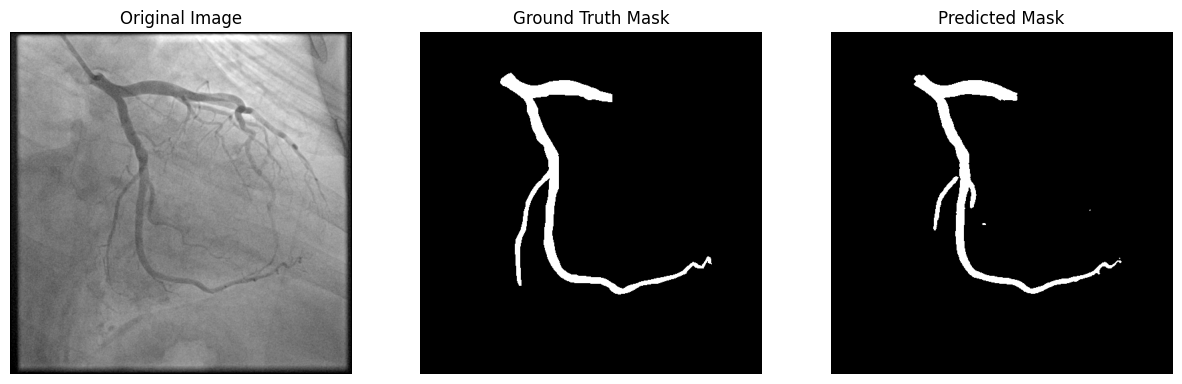

Image 2: True mask sum: 7860.0, Predicted mask sum: 6002


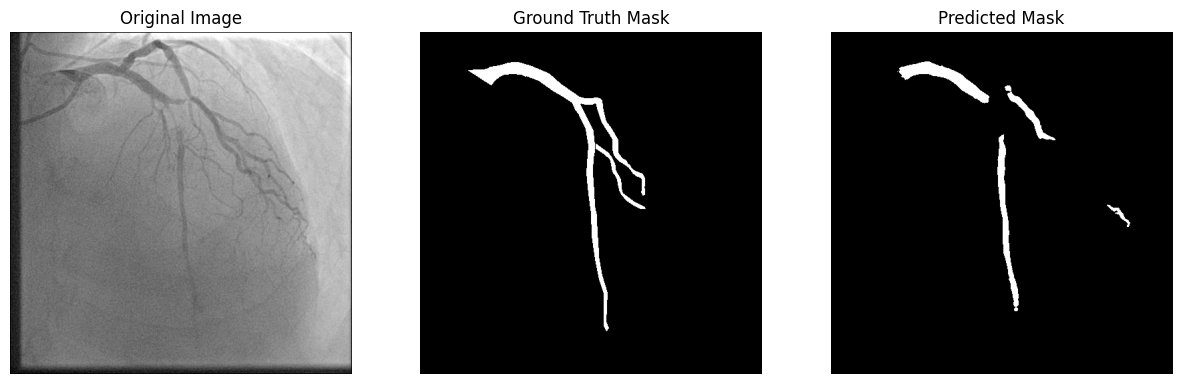

Image 3: True mask sum: 6711.0, Predicted mask sum: 4524


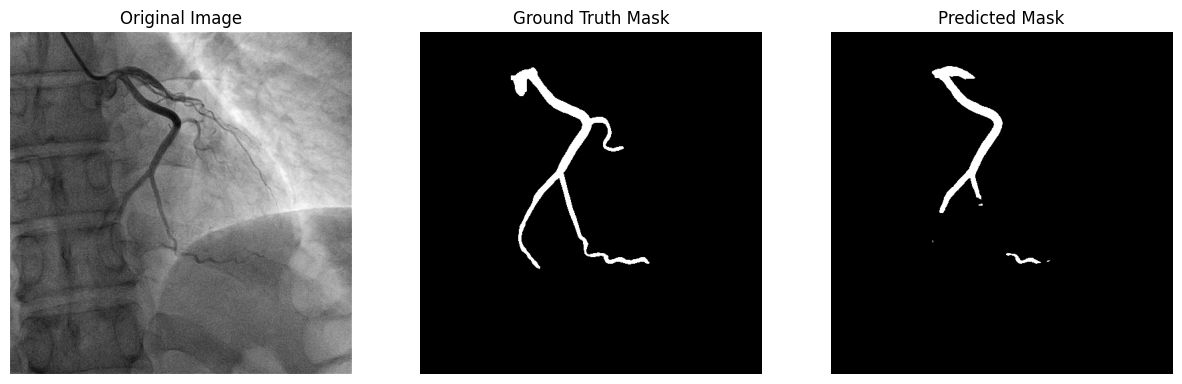

Image 4: True mask sum: 5394.0, Predicted mask sum: 7558


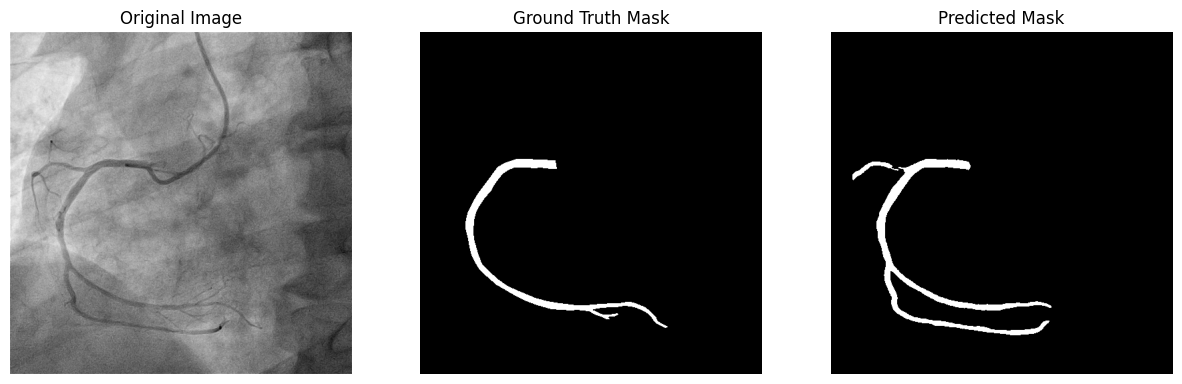

Image 5: True mask sum: 9790.0, Predicted mask sum: 9779


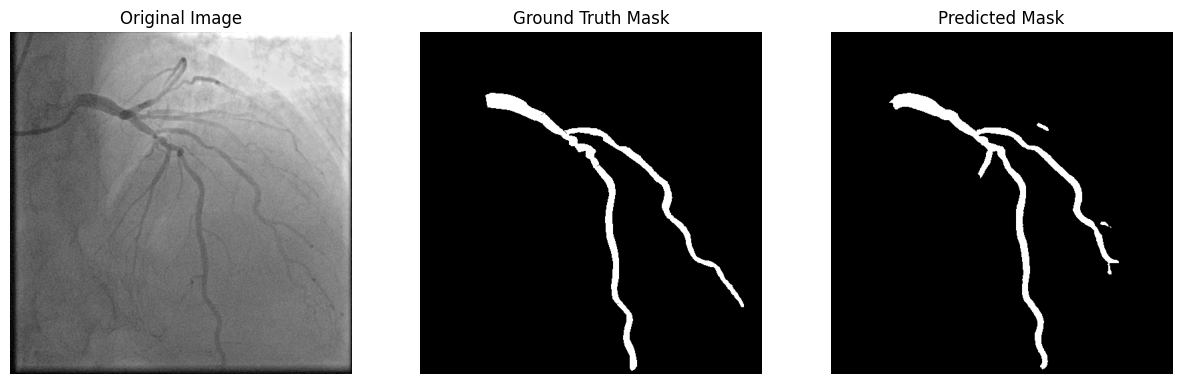

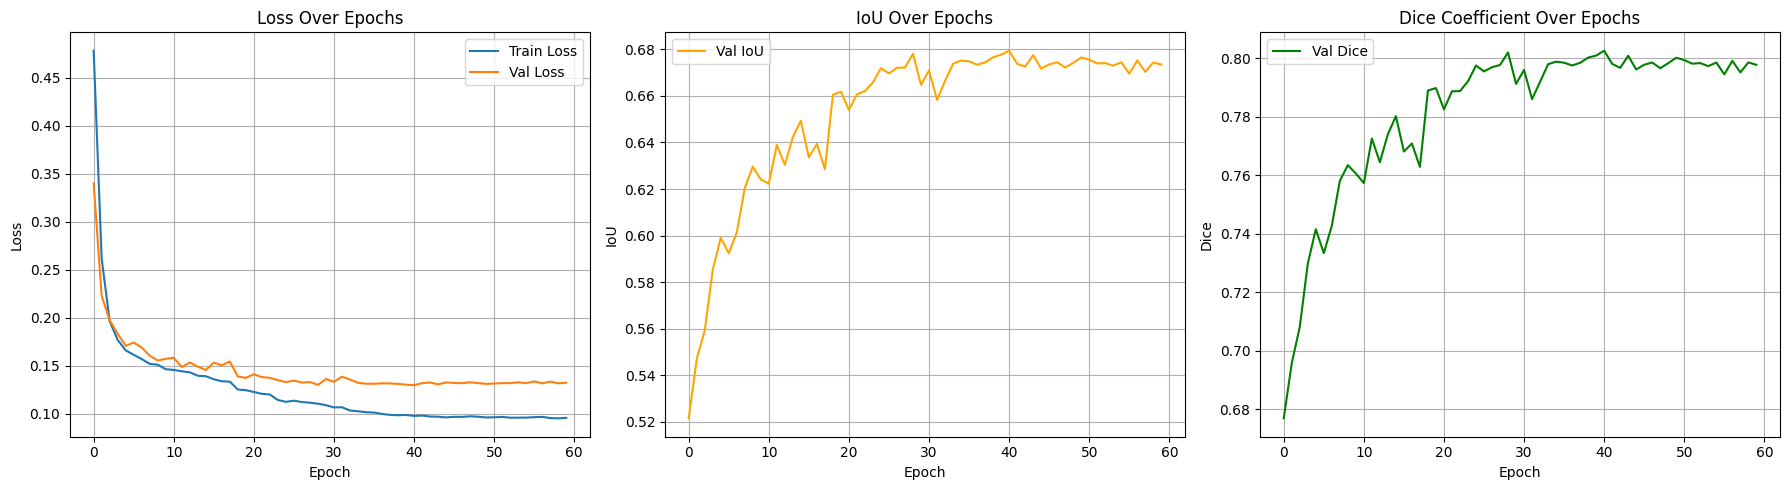

In [10]:
print("Training U-Net++...")
unetpp_model = NestedUNet(num_classes=1, input_channels=1, deep_supervision=False)
trained_unetpp, train_losses, val_losses, val_ious, val_dices = train_model(
    unetpp_model, train_loader, val_loader, num_epochs=60, device=device, deep_supervision=False)

if Path("best_unetpp_model.pth").exists():
    trained_unetpp.load_state_dict(torch.load("best_unetpp_model.pth"))
    print("Loaded best U-Net++ model for visualization.")
else:
    print("No best U-Net++ model saved. Using the last trained model.")

# Visualize U-Net++ predictions
print("Visualizing U-Net++ predictions...")
visualize_predictions(trained_unetpp, val_loader, device, num_images=5, deep_supervision=False)

# Plot training metrics
plt.figure(figsize=(18, 5)) 

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_ious, label='Val IoU', color='orange')
plt.title('IoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(val_dices, label='Val Dice', color='green')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()